# **Stock Price Prediction**


*   In this project, we will be talking about predicting the returns on stocks. 
*   We will predict the stock price using the LSTM neural network.
*   The data contains records about the stock price of Tata Global Beverages Limited. The dataset also contains a date-wise price of stock with open, close, high, and low prices along with volume traded as well as turnover on that day.

### 1.    Imports

In [1]:
import os
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10


from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

2022-07-08 06:04:43.893863: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-08 06:04:43.896867: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-08 06:04:43.896877: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 2. Connection to mysql server

In [3]:
# Set environment variables
os.environ['MYSQL_DB_USERNAME'] = input("Enter the username of the environment variable:")
os.environ['MYSQL_DB_PASSWORD'] = input("Enter the password of the environment variable:")

# Get environment variables
user_name = os.environ.get('MYSQL_DB_USERNAME')
password = os.environ.get('MYSQL_DB_PASSWORD')

In [4]:
# DEFINE THE DATABASE CREDENTIALS
user = user_name
password = password
host = 'localhost'
port = 3306
database = 'schema_2_'
  
# PYTHON FUNCTION TO CONNECT TO THE MYSQL DATABASE AND
engine= create_engine(url="mysql+pymysql://{0}:{1}@{2}:{3}/{4}".format(user, password, host, port, database))
connection=engine.connect()

## 3.   Read the dataset:

In [5]:
query = """SELECT * FROM schema_2_.Stock_Price_Predicton;"""

df = pd.read_sql(query, con=connection)

In [6]:
df.head()

,Date,Open,High,Low,Last,Close,Total_Trade_Quantity,Turnover_Lacs
0,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94
1,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
2,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
3,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
4,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09


 ## 4. Analyze the prices

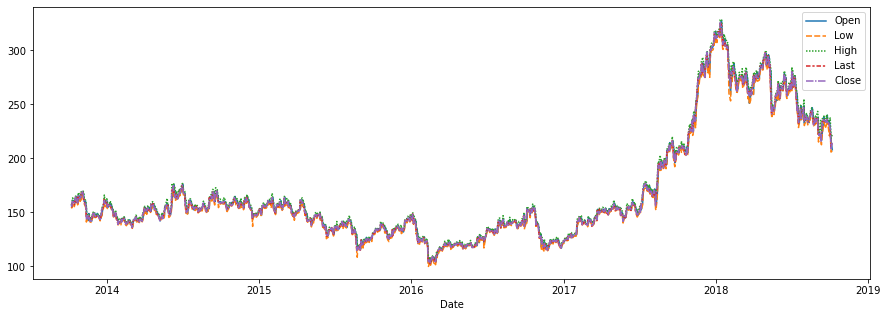

In [7]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
df.drop('Date', axis=1, inplace=True)

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
ax = sns.lineplot(data=df[['Open', 'Low', 'High', 'Last', 'Close']])

## 5. Data Distribution

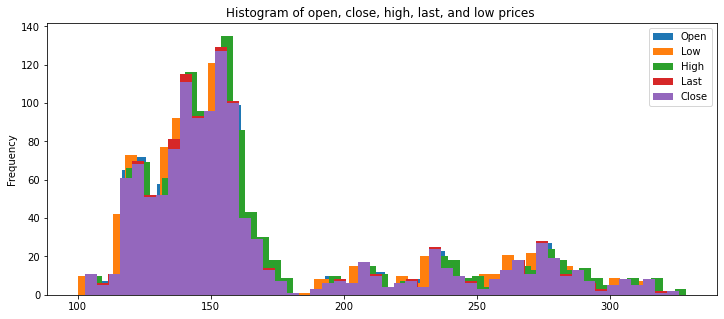

In [8]:
# Creating the plots by iterating through each race
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

for column in ['Open', 'Low', 'High', 'Last', 'Close']:
    plt.hist(df[column], label = column,bins = 50)
    plt.title("Histogram of open, close, high, last, and low prices ")
    plt.ylabel("Frequency")

plt.legend()
plt.show()

While this is an informative plot to have, it does become difficult when making certain comparisons. Therefore, It would be beneficial to have a separate plot for each race which may best be combined into a single graphic as subplots.

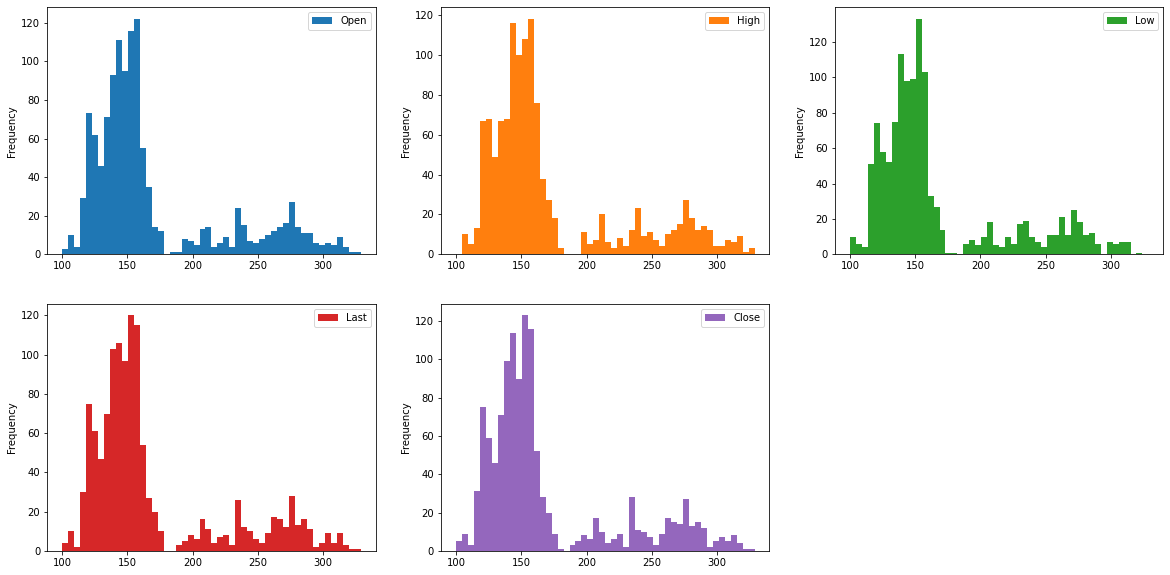

In [9]:
# Creating a deep copy of our dataframe so it may be modified with affecting the original
df1 = df.copy(deep=True)
df1.drop('Total_Trade_Quantity', axis=1, inplace=True)
df1.drop('Turnover_Lacs', axis=1, inplace=True)

df1.plot(kind='hist', subplots=True, layout=(2,3), sharex=False,bins = 50)
plt.show()

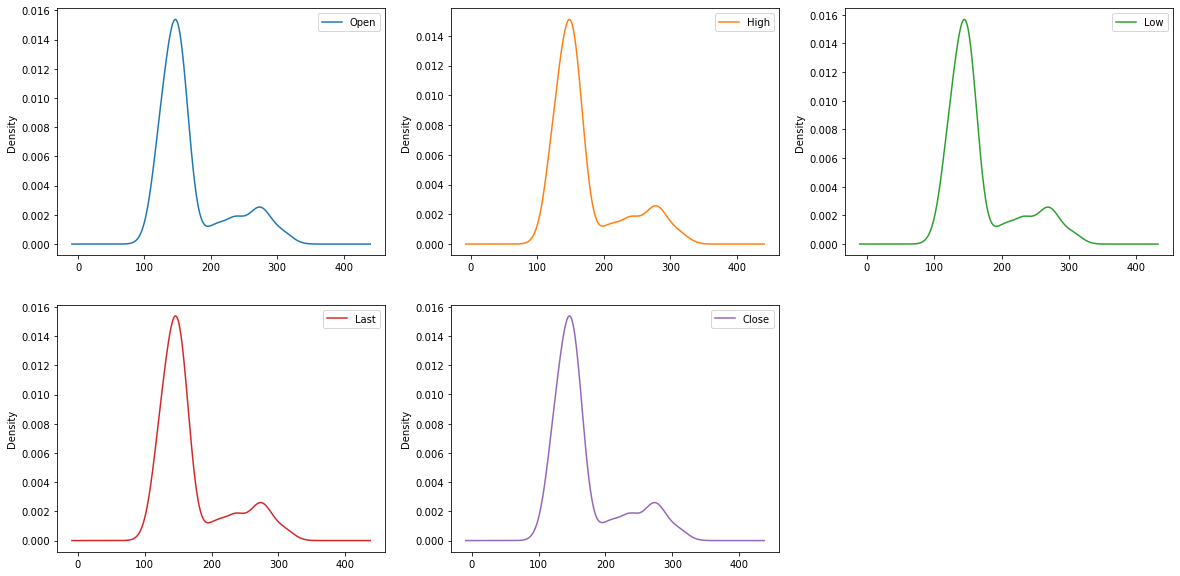

In [10]:
df1.plot(kind='density', subplots=True, layout=(2,3), sharex=False)
plt.show()

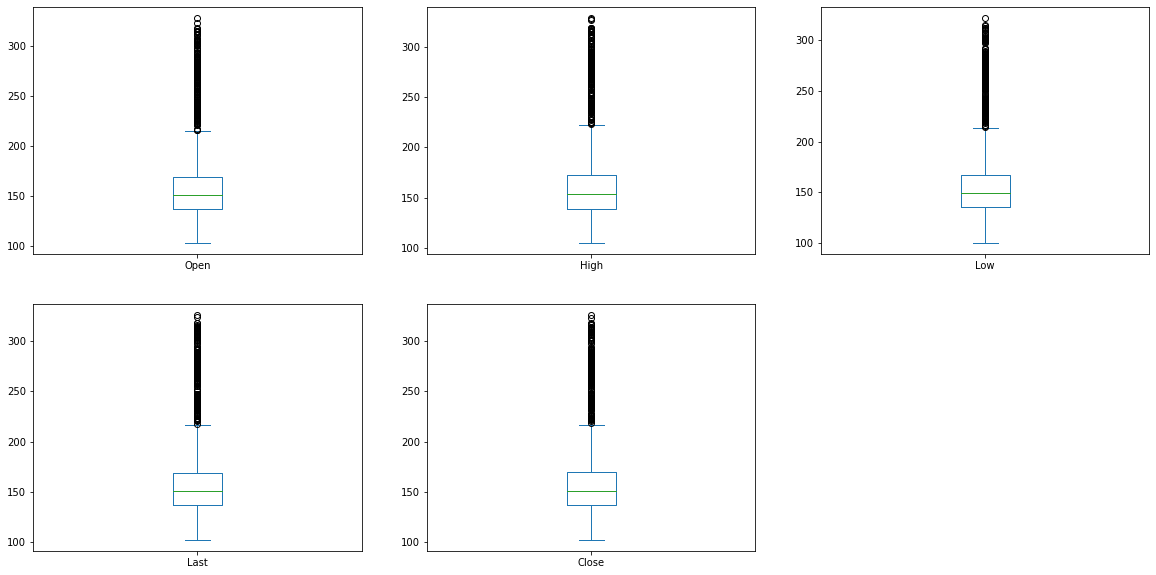

In [11]:
df1.plot(kind='box', subplots=True, layout=(2,3), sharex=False, sharey=False)
plt.show()

## 5. Dimensionality Reduction: Drop Highly Correlated Features

We will drop columns that are well correalated within the 'Close' column


In [12]:
df = df[ ['Close'] + [ col for col in df.columns if col != 'Close' ] ]
df.head()

,Close,Open,High,Low,Last,Total_Trade_Quantity,Turnover_Lacs
Date,,,,,,,
2013-10-08,155.80,157.00,157.80,155.20,155.8,1720413.0,2688.94
2013-10-09,155.55,155.70,158.20,154.15,155.3,2049580.0,3204.49
2013-10-10,160.15,156.00,160.80,155.85,160.3,3124853.0,4978.80
2013-10-11,160.05,161.15,163.45,159.00,159.8,1880046.0,3030.76
2013-10-14,159.45,160.85,161.45,157.70,159.3,1281419.0,2039.09


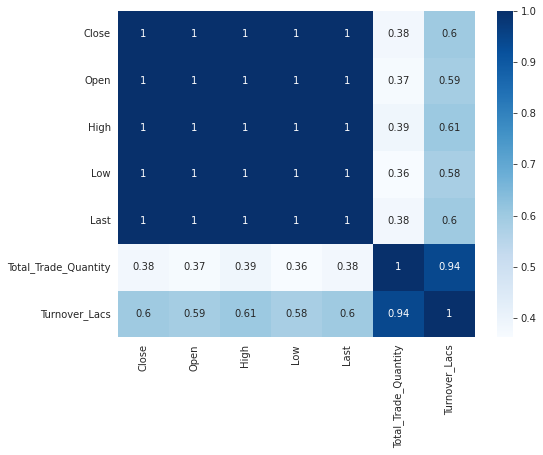

In [13]:
sns.set_style('white')
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(8, 6))
sns.heatmap(df.iloc[:df.shape[0]].corr(), annot = True, cmap = 'Blues')
plt.show()

In [14]:
# Creating a deep copy of our dataframe so it may be modified with affecting the original
df_copy = df.copy(deep=True)

# Create correlation matrix
corr_matrix = df_copy.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

/tmp/ipykernel_24808/2375562652.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [15]:
# Drop features 
df_copy=df_copy.drop(df_copy[to_drop], axis=1)
df_copy.head()

,Close,Total_Trade_Quantity,Turnover_Lacs
Date,,,
2013-10-08,155.80,1720413.0,2688.94
2013-10-09,155.55,2049580.0,3204.49
2013-10-10,160.15,3124853.0,4978.80
2013-10-11,160.05,1880046.0,3030.76
2013-10-14,159.45,1281419.0,2039.09


### 6. Normalize the dataset:

We'll now make modifications to our dataset to groom it into a format useable by our machine learning model.
We will apply the following Scaling Techniques:
* MinMax Scaler
* Standard Scaler
* MaxAbsScaler
* Robust Scaler
* Quantile Transformer Scaler
* Log Transformation
* Power Transformer Scaler
* Unit Vector Scaler/Normalizer

In [16]:
df_copy.drop(['Total_Trade_Quantity','Turnover_Lacs'],axis=1,inplace=True)

In [17]:
df_copy.head()

,Close
Date,
2013-10-08,155.80
2013-10-09,155.55
2013-10-10,160.15
2013-10-11,160.05
2013-10-14,159.45


In [18]:
col = df_copy['Close'].values.reshape(-1, 1)

scalers = [
    #('Unscaled data', X),
    ('L1 normalizing', Normalizer(norm = 'l1')),
    ('L2 normalizing', Normalizer(norm = 'l2')),
    ('standard scaling', StandardScaler()),
    ('min-max scaling', MinMaxScaler()),
    ('max-abs scaling', MaxAbsScaler()),
    ('robust scaling', RobustScaler(quantile_range=(25, 75))),
    ('quantile transformation (uniform pdf)', QuantileTransformer(output_distribution='uniform')),
    ('quantile transformation (gaussian pdf)', QuantileTransformer(output_distribution='normal')),
    ('power transformer scaling box-cox', PowerTransformer(method = 'box-cox')),
    ('power transformer scaling yeo-johnson', PowerTransformer(method = 'yeo-johnson')),
    ('log scaling', FunctionTransformer(np.log, validate = True)),
    ('log2 scaling', FunctionTransformer(np.log2, validate = True))
]


for scaler in scalers:
    df_copy[scaler[0]] = scaler[1].fit_transform(col)

    
df_copy.head()

,Close,L1 normalizing,L2 normalizing,standard scaling,min-max scaling,max-abs scaling,robust scaling,quantile transformation (uniform pdf),quantile transformation (gaussian pdf),power transformer scaling box-cox,power transformer scaling yeo-johnson,log scaling,log2 scaling
Date,,,,,,,,,,,,,
2013-10-08,155.80,1.0,1.0,-0.250971,0.238234,0.478281,0.145624,0.607997,0.274102,0.082854,0.082740,5.048573,7.283551
2013-10-09,155.55,1.0,1.0,-0.255823,0.237113,0.477513,0.137878,0.602603,0.260089,0.075430,0.075313,5.046967,7.281235
2013-10-10,160.15,1.0,1.0,-0.166545,0.257732,0.491635,0.280403,0.689556,0.494592,0.206590,0.206523,5.076111,7.323280
2013-10-11,160.05,1.0,1.0,-0.168485,0.257284,0.491328,0.277304,0.687196,0.487918,0.203857,0.203788,5.075486,7.322379
2013-10-14,159.45,1.0,1.0,-0.180130,0.254594,0.489486,0.258714,0.680681,0.469603,0.187350,0.187275,5.071730,7.316960


In [19]:
column=[]
Mean=[]
Median=[]
Mode=[]

for itm in df_copy.columns:
    column.append(itm)
    
    mean = df_copy[itm].mean()
    Mean.append(mean)

    median = df_copy[itm].median()
    Median.append(median)
    
    mode = df_copy[itm].mode()
    Mode.append(mode[0])

stat = pd.DataFrame({'Scalers': column,
                     'Mean': Mean,
                   'Median': Median,
                   'Mode': Mode})

stat.index=stat['Scalers']
stat

,Scalers,Mean,Median,Mode
Scalers,,,,
Close,Close,1.687311e+02,151.100000,124.450000
L1 normalizing,L1 normalizing,1.000000e+00,1.000000,1.000000
L2 normalizing,L2 normalizing,1.000000e+00,1.000000,1.000000
standard scaling,standard scaling,2.707686e-16,-0.342191,-0.859425
min-max scaling,min-max scaling,2.961948e-01,0.217167,0.097714
max-abs scaling,max-abs scaling,5.179771e-01,0.463853,0.382041
robust scaling,robust scaling,5.462758e-01,0.000000,-0.825716
quantile transformation (uniform pdf),quantile transformation (uniform pdf),5.000024e-01,0.499499,0.121622
quantile transformation (gaussian pdf),quantile transformation (gaussian pdf),8.851317e-06,-0.001255,-1.166919


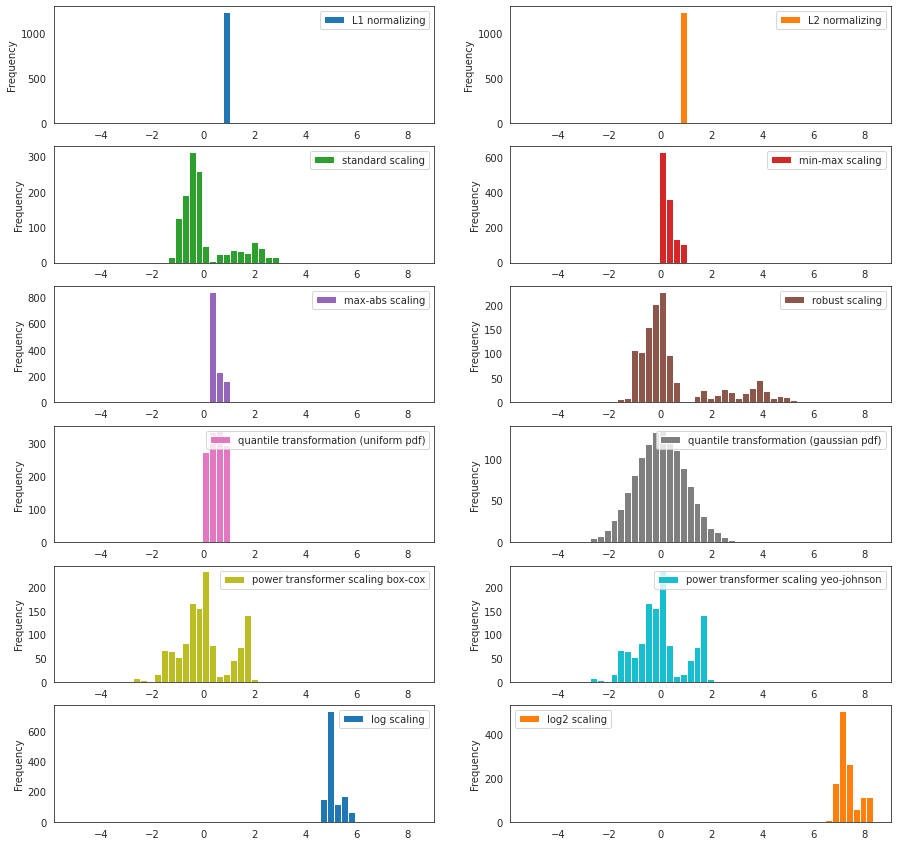

In [20]:
df_copy.drop(['Close'],axis=1,inplace=True)

df_copy.plot(kind='hist', subplots=True, layout=(6,2), sharex=False,bins = 50, figsize=(15,15))
plt.show()

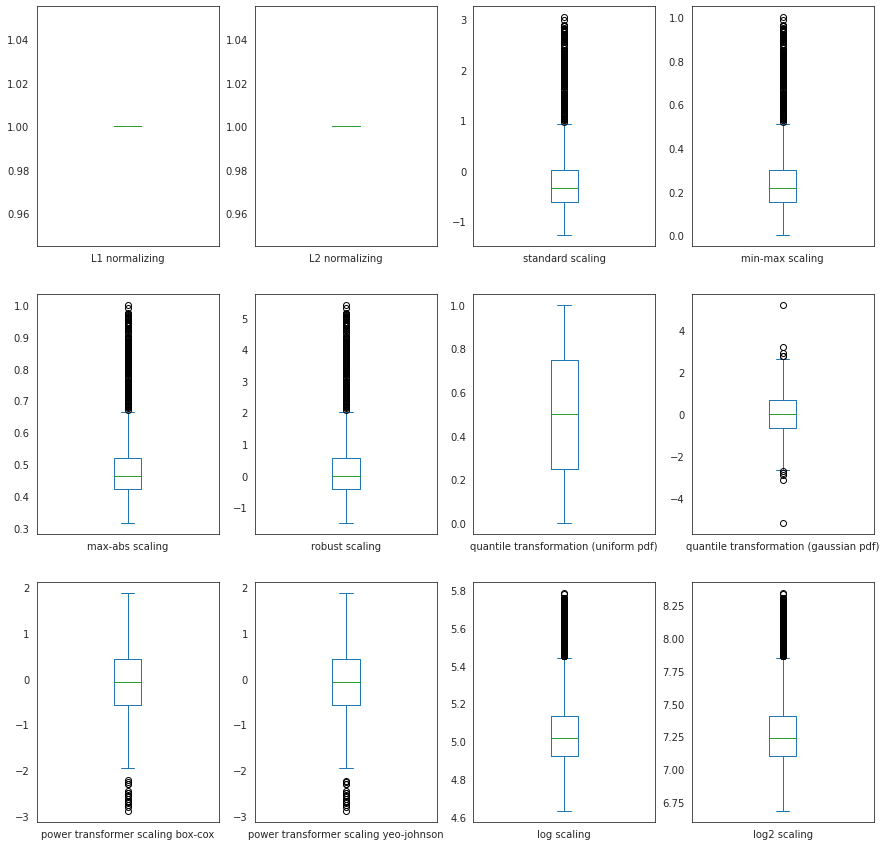

In [21]:
df_copy.plot(kind='box', subplots=True, layout=(3,4), sharex=False, figsize=(15,15))
plt.show()

In [22]:
df_normalized = pd.DataFrame()
df_normalized['quantile transformation (gaussian pdf)'] = df_copy['quantile transformation (gaussian pdf)'].values
df_normalized.head()

,quantile transformation (gaussian pdf)
0,0.274102
1,0.260089
2,0.494592
3,0.487918
4,0.469603


<AxesSubplot:ylabel='Density'>

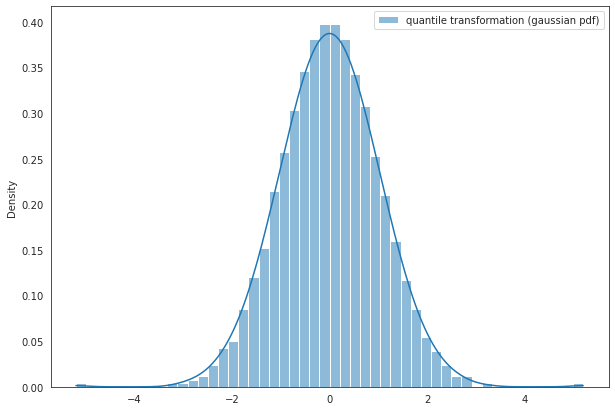

In [23]:
plt.figure(figsize=(10,7))
sns.histplot(data=df_normalized,  stat = 'density', \
             common_norm = False, bins = 50, kde = True, legend = True)

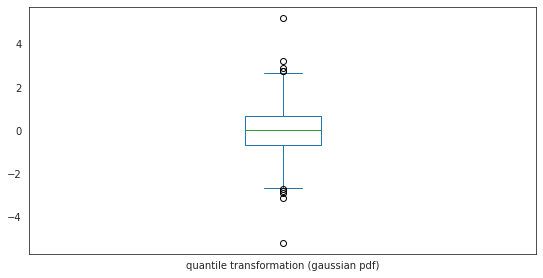

In [24]:
# Box and whisker plots
df_normalized.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

In [25]:
# split & reshape   
train_size=int(0.8*len(df)) 
x_train_data,y_train_data=[],[]


normalized=df_normalized

for i in range(60,train_size):
    x_train_data.append(normalized.iloc[i-60:i,0].values)
    y_train_data.append(normalized.iloc[i,0])
    
x_train_data = np.array(x_train_data)
y_train_data = np.array(y_train_data)
print(x_train_data.shape)
print(y_train_data.shape)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))
print(x_train_data.shape)

(928, 60)
(928,)
(928, 60, 1)


### 7. Build and train the LSTM model:

In [26]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(Dropout(0.3))

lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.3))

lstm_model.add(Dense(1))


lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=1)
lstm_model.summary()

2022-07-08 06:05:25.682725: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-08 06:05:25.682765: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-08 06:05:25.682790: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Mohamed-HP-250-G8): /proc/driver/nvidia/version does not exist
2022-07-08 06:05:25.683104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


928/928 [==============================] - 11s 11ms/step - loss: 0.0994
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
______________________________________________

### 8. Preparing the test data.

In [27]:
df_test = pd.DataFrame()
df_test= df['Close']

scaler=QuantileTransformer(output_distribution='normal')

test_data=df_test[train_size-60:].values.reshape(-1, 1)
test_data=scaler.fit_transform(test_data)

X_test=[]
for i in range(60,test_data.shape[0]):
    X_test.append(test_data[i-60:i,0])

X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)


(247, 60, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (307). n_quantiles is set to n_samples.
  warnings.warn(


### 9.Predicting the Values for test data

In [28]:
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

8/8 [==============================] - 0s 7ms/step


### 10. Save the LSTM model:

In [29]:
lstm_model.save("saved_model.h5")

### 11. Visualize the predicted stock costs with actual stock costs:

/tmp/ipykernel_24808/2697590860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


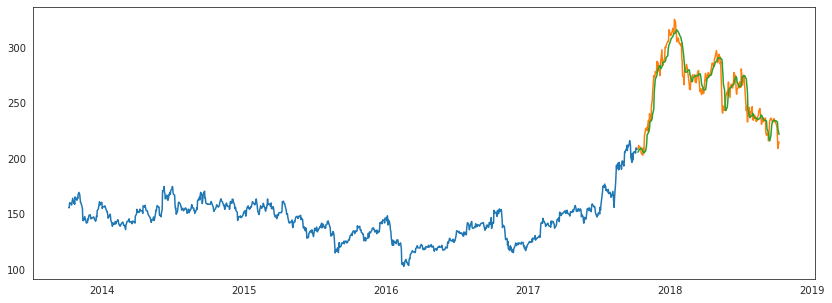

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 5)

train_data=df[:train_size]
valid_data=df[train_size:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])